## 3-Species Lotka Volterra
$\begin{cases}
        \frac{du_1}{dt} = u_1(\mu-\theta_{11}\,u_1-\theta_{12}\,u_2-\theta_{13}\,u_3)\\
        \frac{du_2}{dt} = u_2(-\mu+\theta_{21}\,u_1-\theta_{23}\,u_3)\\
        \frac{du_3}{dt} = u_3(-\mu+\theta_{31}\,u_1+\theta_{32}\,u_2)\\
        u_i(0) = u_0\;\;\;\forall\;i\,\in\,\left\{1,\,2,\,3\right\}
    \end{cases}$
    
In this notebook, we want to stress the library, by trying to estimate 8 parameters together, and test the efficiency of the 2 most used models (HMC and DEns)

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data_inv():
    data = sio.loadmat("../dataset/3_species_20.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.1
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test

In [6]:
def ode3_fn(t, u, mu, t11, t12, t13, t21, t23, t31, t32):
    
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t, u2_t, u3_t = tf.gradients(u1,t)[0], tf.gradients(u2,t)[0], tf.gradients(u3,t)[0]
    
    f1 = u1_t - u1*(mu - t11*u1 - t12*u2 - t13*u3)
    f2 = u2_t - u2*(-mu + t21*u1 - t23*u3)
    f3 = u3_t - u3*(-mu + t31*u1 + t32*u2)
    
    return tf.concat([f1,f2, f3], axis=-1)

In [7]:
@neuq.utils.timer
def Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train[:20]
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:20, 2:3]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        prior=neuq_vars.fnn.Samplable(layers=layers, mean=3, sigma=2),
    )
    process_mu = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=1, sigma=1),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    process_r7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Samplable(mean=0, sigma=1),
    )
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
        sigma=noise,
    )
    likelihood_u3 = neuq.likelihoods.Normal(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
        sigma=noise,
    )
    
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_mu, process_r1, process_r2, process_r3, process_r4, process_r5, process_r6, process_r7],
        pde=ode3_fn,
        sigma=noise,
    )
    
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_mu, process_r1, process_r2, process_r3, process_r4, process_r5, process_r6, process_r7],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    
    # assign and compile method
    # Change parameters to make the acceptance rate close to 0.6.
    method = neuq.inferences.HMC(
        num_samples=2000,
        num_burnin=5000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=777,
    )
    model.compile(method)
    
    # obtain posterior samples
    samples, results = model.run()
    print("Acceptance rate: %.3f \n"%(np.mean(results)))
    
    processes = [process_u, process_mu, process_r1, process_r2, process_r3, process_r4, process_r5, process_r6, process_r7]

    return processes, samples, model

@neuq.utils.timer
def Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers):
    t_u3_train = t_u_train[:20]
    u1_train, u2_train, u3_train = u_train[:, 0:1], u_train[:, 1:2], u_train[:20, 2:3]
    
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers),
        posterior=neuq_vars.fnn.Trainable(
            layers=layers, regularizer=tf.keras.regularizers.l2(1e-7)
        ),
    )
    process_mu = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r1 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r2 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r3 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r4 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r5 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r6 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    process_r7 = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        posterior=neuq_vars.const.Trainable(value=0),
    )
    
    # build likelihood
    likelihood_u12 = neuq.likelihoods.MSE(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u2_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 1]],
    )
    likelihood_u3 = neuq.likelihoods.MSE(
        inputs=t_u3_train,
        targets=u3_train,
        processes=[process_u],
        out_dims=[[2]],
    )
    
    likelihood_f = neuq.likelihoods.MSE(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_mu, process_r1, process_r2, process_r3, process_r4, process_r5, process_r6, process_r7],
        pde=ode3_fn,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_mu, process_r1, process_r2, process_r3, process_r4, process_r5, process_r6, process_r7],
        likelihoods=[likelihood_u12, likelihood_u3, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.DEns(
        num_samples=20, num_iterations=20000, optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()
    samples = neuq.utils.batch_samples(samples)  # reshape

    processes = [process_u, process_mu, process_r1, process_r2, process_r3, process_r4, process_r5, process_r6, process_r7]
    return processes, samples, model

################## Load data and specify some hyperparameters ####################
t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test = load_data_inv()

layers = [1, 50, 50, 3]

In [8]:
def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u2_train = u_train[:,0:1], u_train[:,1:2]  # training data
    t_u3_train = t_u_train[:20]
    u3_train = u_train[:20, 2:3]

    neuq.utils.hist(mu_pred, name="value of $mu$")
    neuq.utils.hist(r1_pred, name=r"value of $\theta_{11}$")
    neuq.utils.hist(r2_pred, name=r"value of $\theta_{12}$")
    neuq.utils.hist(r3_pred, name=r"value of $\theta_{13}$")
    neuq.utils.hist(r4_pred, name=r"value of $\theta_{21}$")
    neuq.utils.hist(r5_pred, name=r"value of $\theta_{23}$")
    neuq.utils.hist(r6_pred, name=r"value of $\theta_{31}$")
    neuq.utils.hist(r7_pred, name=r"value of $\theta_{32}$")
    
    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
    )
    neuq.utils.plot1d(
        t_u_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
    )
    neuq.utils.plot1d(
        t_u3_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
    )

In [9]:
############################### Choose framework #################################
processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

#processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.385 

Execution time for 'Samplable' function is: 191.876 s, 3.198 mins


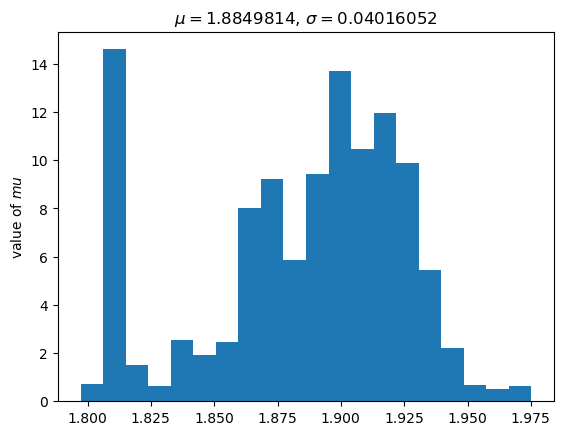

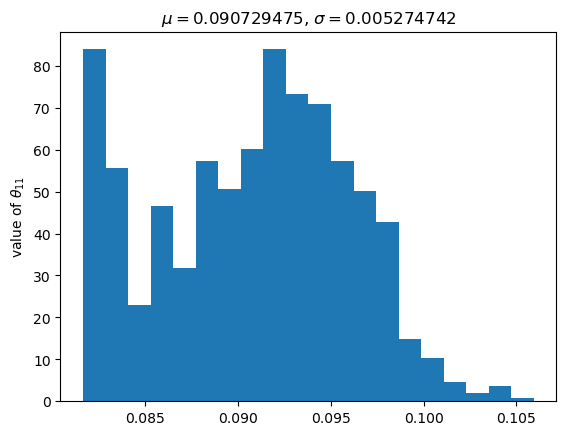

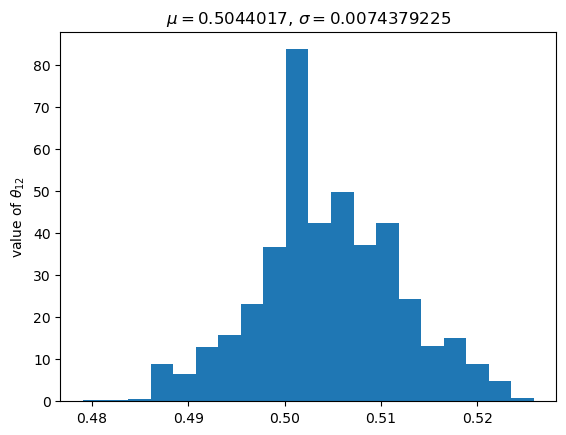

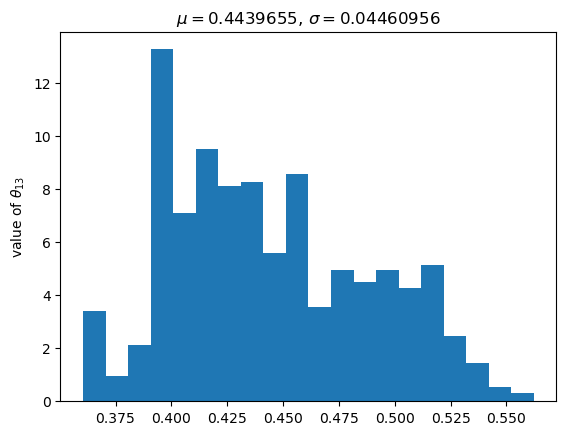

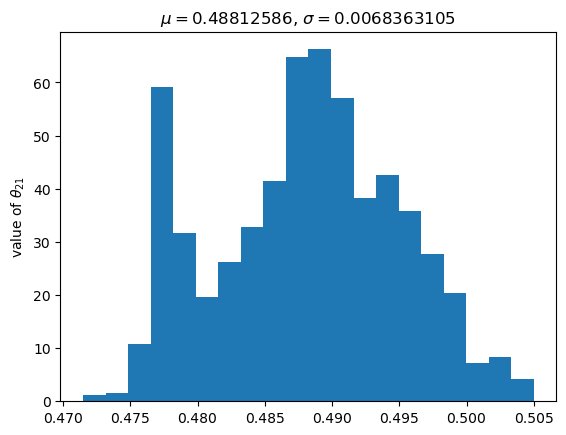

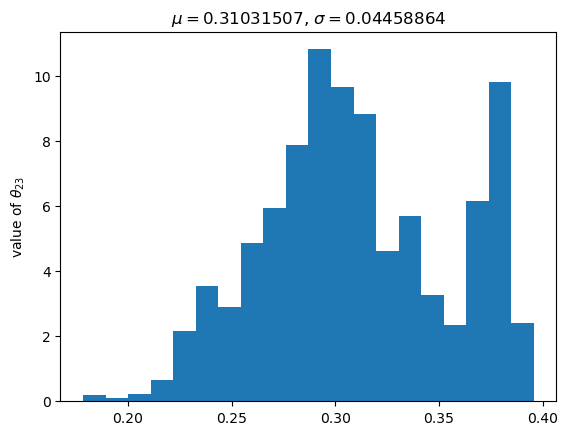

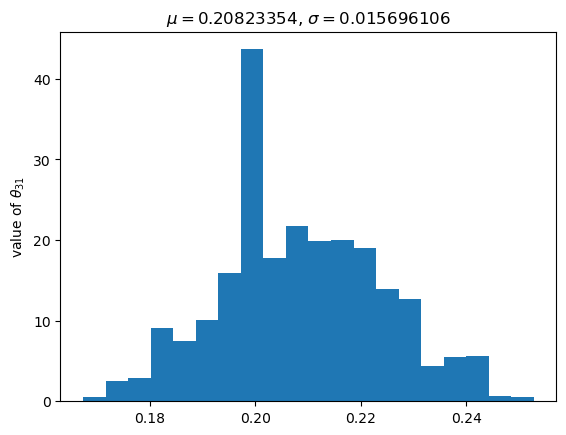

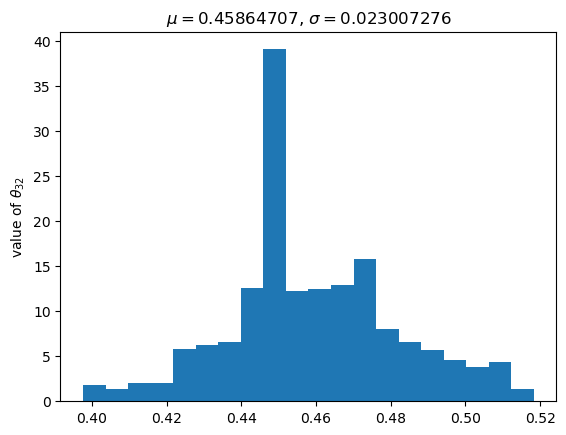

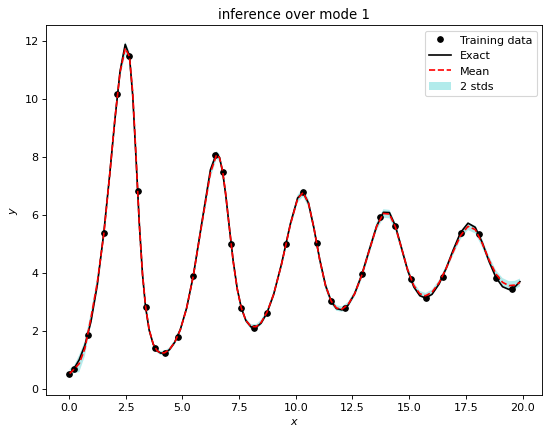

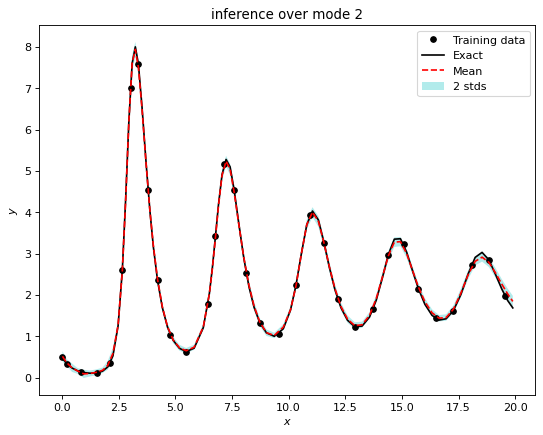

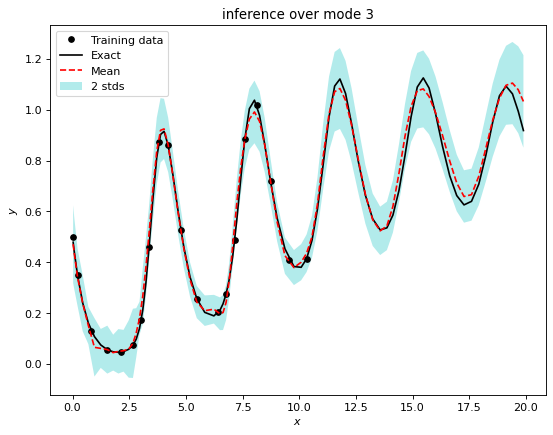

In [10]:
u_pred, mu_pred, r1_pred, r2_pred, r3_pred, r4_pred, r5_pred, r6_pred, r7_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)

In [11]:
############################### Choose framework #################################
#processes, samples, model = Samplable(t_u_train, u_train, t_f_train, f_train, noise, layers)

processes, samples, model = Trainable(t_u_train, u_train, t_f_train, f_train, noise, layers)

Supporting backend tensorflow.compat.v1

Compiling a Ensemble method

Generating 0th sample by deep ensemble...
Iteration:  0 , loss:  15.339981
Iteration:  100 , loss:  4.3964086
Iteration:  200 , loss:  4.1911387
Iteration:  300 , loss:  4.0780067
Iteration:  400 , loss:  3.982087
Iteration:  500 , loss:  3.8089547
Iteration:  600 , loss:  3.4783964
Iteration:  700 , loss:  3.0042787
Iteration:  800 , loss:  2.5574172
Iteration:  900 , loss:  2.1937852
Iteration:  1000 , loss:  1.9024644
Iteration:  1100 , loss:  1.6876955
Iteration:  1200 , loss:  1.5358102
Iteration:  1300 , loss:  1.4250787
Iteration:  1400 , loss:  1.3407997
Iteration:  1500 , loss:  1.269229
Iteration:  1600 , loss:  1.198921
Iteration:  1700 , loss:  1.1256461
Iteration:  1800 , loss:  1.0497323
Iteration:  1900 , loss:  0.97716373
Iteration:  2000 , loss:  0.91257966
Iteration:  2100 , loss:  0.85545385
Iteration:  2200 , loss:  0.8016826
Iteration:  2300 , loss:  0.75337166
Iteration:  2400 , loss:  0.7111605

Iteration:  1700 , loss:  1.2798826
Iteration:  1800 , loss:  1.2293948
Iteration:  1900 , loss:  1.1833029
Iteration:  2000 , loss:  1.1361673
Iteration:  2100 , loss:  1.0841867
Iteration:  2200 , loss:  1.0255755
Iteration:  2300 , loss:  0.96146864
Iteration:  2400 , loss:  0.8955077
Iteration:  2500 , loss:  0.83136374
Iteration:  2600 , loss:  0.77182
Iteration:  2700 , loss:  0.71782297
Iteration:  2800 , loss:  0.66847366
Iteration:  2900 , loss:  0.6246907
Iteration:  3000 , loss:  0.58921933
Iteration:  3100 , loss:  0.5629143
Iteration:  3200 , loss:  0.5440787
Iteration:  3300 , loss:  0.53040504
Iteration:  3400 , loss:  0.5181866
Iteration:  3500 , loss:  0.5056692
Iteration:  3600 , loss:  0.49230915
Iteration:  3700 , loss:  0.47581258
Iteration:  3800 , loss:  0.46034026
Iteration:  3900 , loss:  0.44837222
Iteration:  4000 , loss:  0.43834722
Iteration:  4100 , loss:  0.42890775
Iteration:  4200 , loss:  0.4189768
Iteration:  4300 , loss:  0.40747935
Iteration:  4400 

Iteration:  3600 , loss:  0.35200265
Iteration:  3700 , loss:  0.3367993
Iteration:  3800 , loss:  0.32116675
Iteration:  3900 , loss:  0.3006941
Iteration:  4000 , loss:  0.27936658
Iteration:  4100 , loss:  0.2600143
Iteration:  4200 , loss:  0.24190307
Iteration:  4300 , loss:  0.22556639
Iteration:  4400 , loss:  0.21267629
Iteration:  4500 , loss:  0.20240135
Iteration:  4600 , loss:  0.19479069
Iteration:  4700 , loss:  0.18864655
Iteration:  4800 , loss:  0.18357718
Iteration:  4900 , loss:  0.17803077
Iteration:  5000 , loss:  0.17334682
Iteration:  5100 , loss:  0.1691844
Iteration:  5200 , loss:  0.16564327
Iteration:  5300 , loss:  0.16222325
Iteration:  5400 , loss:  0.15917337
Iteration:  5500 , loss:  0.15633719
Iteration:  5600 , loss:  0.15357962
Iteration:  5700 , loss:  0.15042906
Iteration:  5800 , loss:  0.14625105
Iteration:  5900 , loss:  0.14104111
Iteration:  6000 , loss:  0.13588268
Iteration:  6100 , loss:  0.13124277
Iteration:  6200 , loss:  0.12707339
Itera

Iteration:  5200 , loss:  0.2476458
Iteration:  5300 , loss:  0.23526591
Iteration:  5400 , loss:  0.22784221
Iteration:  5500 , loss:  0.22281733
Iteration:  5600 , loss:  0.21892656
Iteration:  5700 , loss:  0.21560362
Iteration:  5800 , loss:  0.21289568
Iteration:  5900 , loss:  0.21030751
Iteration:  6000 , loss:  0.20807822
Iteration:  6100 , loss:  0.20616108
Iteration:  6200 , loss:  0.20400731
Iteration:  6300 , loss:  0.20202672
Iteration:  6400 , loss:  0.19996805
Iteration:  6500 , loss:  0.19766675
Iteration:  6600 , loss:  0.19500612
Iteration:  6700 , loss:  0.19189732
Iteration:  6800 , loss:  0.1882698
Iteration:  6900 , loss:  0.18397546
Iteration:  7000 , loss:  0.17916398
Iteration:  7100 , loss:  0.17416297
Iteration:  7200 , loss:  0.16954659
Iteration:  7300 , loss:  0.16560352
Iteration:  7400 , loss:  0.16226836
Iteration:  7500 , loss:  0.15946962
Iteration:  7600 , loss:  0.15847874
Iteration:  7700 , loss:  0.15475944
Iteration:  7800 , loss:  0.1526624
Iter

Iteration:  7000 , loss:  0.17897525
Iteration:  7100 , loss:  0.17585126
Iteration:  7200 , loss:  0.1733444
Iteration:  7300 , loss:  0.17151165
Iteration:  7400 , loss:  0.1701322
Iteration:  7500 , loss:  0.16903809
Iteration:  7600 , loss:  0.1681433
Iteration:  7700 , loss:  0.16736086
Iteration:  7800 , loss:  0.1667821
Iteration:  7900 , loss:  0.16612598
Iteration:  8000 , loss:  0.1667741
Iteration:  8100 , loss:  0.164842
Iteration:  8200 , loss:  0.16432448
Iteration:  8300 , loss:  0.1638067
Iteration:  8400 , loss:  0.16331844
Iteration:  8500 , loss:  0.16286407
Iteration:  8600 , loss:  0.16242796
Iteration:  8700 , loss:  0.16200939
Iteration:  8800 , loss:  0.16208774
Iteration:  8900 , loss:  0.1612127
Iteration:  9000 , loss:  0.16084078
Iteration:  9100 , loss:  0.16050033
Iteration:  9200 , loss:  0.16023025
Iteration:  9300 , loss:  0.16028583
Iteration:  9400 , loss:  0.15943469
Iteration:  9500 , loss:  0.15911512
Iteration:  9600 , loss:  0.1589172
Iteration: 

Iteration:  9000 , loss:  0.08804129
Iteration:  9100 , loss:  0.08288628
Iteration:  9200 , loss:  0.07722552
Iteration:  9300 , loss:  0.07130978
Iteration:  9400 , loss:  0.06569854
Iteration:  9500 , loss:  0.060843244
Iteration:  9600 , loss:  0.055975467
Iteration:  9700 , loss:  0.051967483
Iteration:  9800 , loss:  0.048060533
Iteration:  9900 , loss:  0.044734623
Iteration:  10000 , loss:  0.042781074
Iteration:  10100 , loss:  0.03901273
Iteration:  10200 , loss:  0.036475882
Iteration:  10300 , loss:  0.03411833
Iteration:  10400 , loss:  0.0318846
Iteration:  10500 , loss:  0.03171599
Iteration:  10600 , loss:  0.02783283
Iteration:  10700 , loss:  0.02670499
Iteration:  10800 , loss:  0.024525685
Iteration:  10900 , loss:  0.023200464
Iteration:  11000 , loss:  0.022080127
Iteration:  11100 , loss:  0.02117696
Iteration:  11200 , loss:  0.020381046
Iteration:  11300 , loss:  0.01975934
Iteration:  11400 , loss:  0.01918769
Iteration:  11500 , loss:  0.01876791
Iteration:  

Iteration:  10800 , loss:  0.01820332
Iteration:  10900 , loss:  0.017991284
Iteration:  11000 , loss:  0.017782353
Iteration:  11100 , loss:  0.017621454
Iteration:  11200 , loss:  0.017403543
Iteration:  11300 , loss:  0.0192768
Iteration:  11400 , loss:  0.017061725
Iteration:  11500 , loss:  0.016896656
Iteration:  11600 , loss:  0.01674682
Iteration:  11700 , loss:  0.01658621
Iteration:  11800 , loss:  0.016823955
Iteration:  11900 , loss:  0.016295781
Iteration:  12000 , loss:  0.016294053
Iteration:  12100 , loss:  0.016019527
Iteration:  12200 , loss:  0.015881985
Iteration:  12300 , loss:  0.015760485
Iteration:  12400 , loss:  0.015626598
Iteration:  12500 , loss:  0.015575898
Iteration:  12600 , loss:  0.015381795
Iteration:  12700 , loss:  0.01876334
Iteration:  12800 , loss:  0.015145554
Iteration:  12900 , loss:  0.015026717
Iteration:  13000 , loss:  0.014916545
Iteration:  13100 , loss:  0.014803299
Iteration:  13200 , loss:  0.014761475
Iteration:  13300 , loss:  0.01

Iteration:  12600 , loss:  0.020939933
Iteration:  12700 , loss:  0.020698873
Iteration:  12800 , loss:  0.020100797
Iteration:  12900 , loss:  0.019869981
Iteration:  13000 , loss:  0.019435689
Iteration:  13100 , loss:  0.019133147
Iteration:  13200 , loss:  0.019255806
Iteration:  13300 , loss:  0.018604307
Iteration:  13400 , loss:  0.018424995
Iteration:  13500 , loss:  0.018129282
Iteration:  13600 , loss:  0.017900687
Iteration:  13700 , loss:  0.01768427
Iteration:  13800 , loss:  0.017460901
Iteration:  13900 , loss:  0.01724454
Iteration:  14000 , loss:  0.017025735
Iteration:  14100 , loss:  0.01679972
Iteration:  14200 , loss:  0.016619617
Iteration:  14300 , loss:  0.016349366
Iteration:  14400 , loss:  0.016130276
Iteration:  14500 , loss:  0.0159519
Iteration:  14600 , loss:  0.01571115
Iteration:  14700 , loss:  0.01553588
Iteration:  14800 , loss:  0.015302256
Iteration:  14900 , loss:  0.01510041
Iteration:  15000 , loss:  0.015012477
Iteration:  15100 , loss:  0.0147

Iteration:  14500 , loss:  0.007923913
Iteration:  14600 , loss:  0.007623356
Iteration:  14700 , loss:  0.0072296574
Iteration:  14800 , loss:  0.007496117
Iteration:  14900 , loss:  0.0066215466
Iteration:  15000 , loss:  0.0063613877
Iteration:  15100 , loss:  0.0061134985
Iteration:  15200 , loss:  0.0059475806
Iteration:  15300 , loss:  0.005707104
Iteration:  15400 , loss:  0.005613771
Iteration:  15500 , loss:  0.0053868354
Iteration:  15600 , loss:  0.005450371
Iteration:  15700 , loss:  0.005134413
Iteration:  15800 , loss:  0.008959813
Iteration:  15900 , loss:  0.0049302126
Iteration:  16000 , loss:  0.0048399493
Iteration:  16100 , loss:  0.0047630654
Iteration:  16200 , loss:  0.0046886285
Iteration:  16300 , loss:  0.0046223514
Iteration:  16400 , loss:  0.004555525
Iteration:  16500 , loss:  0.0045240093
Iteration:  16600 , loss:  0.004434084
Iteration:  16700 , loss:  0.006791158
Iteration:  16800 , loss:  0.004321447
Iteration:  16900 , loss:  0.00429255
Iteration:  17

Iteration:  15900 , loss:  0.0046868394
Iteration:  16000 , loss:  0.004864315
Iteration:  16100 , loss:  0.004548623
Iteration:  16200 , loss:  0.0044908137
Iteration:  16300 , loss:  0.0049559306
Iteration:  16400 , loss:  0.0043734056
Iteration:  16500 , loss:  0.004407685
Iteration:  16600 , loss:  0.004341431
Iteration:  16700 , loss:  0.004214405
Iteration:  16800 , loss:  0.0042480426
Iteration:  16900 , loss:  0.0041209585
Iteration:  17000 , loss:  0.0040694154
Iteration:  17100 , loss:  0.004079295
Iteration:  17200 , loss:  0.0039795414
Iteration:  17300 , loss:  0.003938162
Iteration:  17400 , loss:  0.0038967254
Iteration:  17500 , loss:  0.0038610932
Iteration:  17600 , loss:  0.003820933
Iteration:  17700 , loss:  0.0037834798
Iteration:  17800 , loss:  0.0038561954
Iteration:  17900 , loss:  0.0037160553
Iteration:  18000 , loss:  0.0036774583
Iteration:  18100 , loss:  0.0037070368
Iteration:  18200 , loss:  0.003611356
Iteration:  18300 , loss:  0.003580877
Iteration:

Iteration:  17600 , loss:  0.0020257747
Iteration:  17700 , loss:  0.0036674002
Iteration:  17800 , loss:  0.0019783457
Iteration:  17900 , loss:  0.002004089
Iteration:  18000 , loss:  0.0038139632
Iteration:  18100 , loss:  0.0019348598
Iteration:  18200 , loss:  0.0019101852
Iteration:  18300 , loss:  0.0018977885
Iteration:  18400 , loss:  0.0020621684
Iteration:  18500 , loss:  0.0024973894
Iteration:  18600 , loss:  0.0018478585
Iteration:  18700 , loss:  0.0018355139
Iteration:  18800 , loss:  0.0018220011
Iteration:  18900 , loss:  0.0018332337
Iteration:  19000 , loss:  0.0018216227
Iteration:  19100 , loss:  0.0021938314
Iteration:  19200 , loss:  0.0017644962
Iteration:  19300 , loss:  0.0017525126
Iteration:  19400 , loss:  0.002090547
Iteration:  19500 , loss:  0.0017270077
Iteration:  19600 , loss:  0.0017173183
Iteration:  19700 , loss:  0.0017093841
Iteration:  19800 , loss:  0.0044816695
Iteration:  19900 , loss:  0.0016841188
Generating 11th sample by deep ensemble...

Iteration:  19100 , loss:  0.0017018892
Iteration:  19200 , loss:  0.0018138184
Iteration:  19300 , loss:  0.0016117288
Iteration:  19400 , loss:  0.0015882425
Iteration:  19500 , loss:  0.0018241844
Iteration:  19600 , loss:  0.0021701502
Iteration:  19700 , loss:  0.0015495884
Iteration:  19800 , loss:  0.0015270485
Iteration:  19900 , loss:  0.0018639612
Generating 12th sample by deep ensemble...
Iteration:  0 , loss:  17.00642
Iteration:  100 , loss:  4.435133
Iteration:  200 , loss:  4.2148433
Iteration:  300 , loss:  4.0808725
Iteration:  400 , loss:  3.9558244
Iteration:  500 , loss:  3.7280898
Iteration:  600 , loss:  3.3311653
Iteration:  700 , loss:  2.8523693
Iteration:  800 , loss:  2.4251223
Iteration:  900 , loss:  2.0833213
Iteration:  1000 , loss:  1.8394027
Iteration:  1100 , loss:  1.6728868
Iteration:  1200 , loss:  1.5578362
Iteration:  1300 , loss:  1.4767158
Iteration:  1400 , loss:  1.4091433
Iteration:  1500 , loss:  1.3458241
Iteration:  1600 , loss:  1.285273


Iteration:  800 , loss:  2.9880404
Iteration:  900 , loss:  2.5990965
Iteration:  1000 , loss:  2.2422035
Iteration:  1100 , loss:  1.9622151
Iteration:  1200 , loss:  1.7714882
Iteration:  1300 , loss:  1.6356035
Iteration:  1400 , loss:  1.518283
Iteration:  1500 , loss:  1.416694
Iteration:  1600 , loss:  1.3360072
Iteration:  1700 , loss:  1.2670662
Iteration:  1800 , loss:  1.1996032
Iteration:  1900 , loss:  1.1268075
Iteration:  2000 , loss:  1.0456998
Iteration:  2100 , loss:  0.96078473
Iteration:  2200 , loss:  0.8797742
Iteration:  2300 , loss:  0.8082841
Iteration:  2400 , loss:  0.74954647
Iteration:  2500 , loss:  0.7025466
Iteration:  2600 , loss:  0.66640675
Iteration:  2700 , loss:  0.63788843
Iteration:  2800 , loss:  0.6142182
Iteration:  2900 , loss:  0.5938
Iteration:  3000 , loss:  0.57503635
Iteration:  3100 , loss:  0.5567895
Iteration:  3200 , loss:  0.5387873
Iteration:  3300 , loss:  0.52238977
Iteration:  3400 , loss:  0.50905097
Iteration:  3500 , loss:  0.

Iteration:  2800 , loss:  0.6939978
Iteration:  2900 , loss:  0.6598139
Iteration:  3000 , loss:  0.6263342
Iteration:  3100 , loss:  0.59635985
Iteration:  3200 , loss:  0.57024914
Iteration:  3300 , loss:  0.5459972
Iteration:  3400 , loss:  0.52427036
Iteration:  3500 , loss:  0.5029402
Iteration:  3600 , loss:  0.48424706
Iteration:  3700 , loss:  0.46760952
Iteration:  3800 , loss:  0.45075995
Iteration:  3900 , loss:  0.43260974
Iteration:  4000 , loss:  0.4144954
Iteration:  4100 , loss:  0.3975258
Iteration:  4200 , loss:  0.381162
Iteration:  4300 , loss:  0.36417645
Iteration:  4400 , loss:  0.34544894
Iteration:  4500 , loss:  0.32586583
Iteration:  4600 , loss:  0.3077397
Iteration:  4700 , loss:  0.29295292
Iteration:  4800 , loss:  0.28127095
Iteration:  4900 , loss:  0.2714832
Iteration:  5000 , loss:  0.26166862
Iteration:  5100 , loss:  0.25028482
Iteration:  5200 , loss:  0.238565
Iteration:  5300 , loss:  0.22863112
Iteration:  5400 , loss:  0.2190466
Iteration:  550

Iteration:  4700 , loss:  0.21019293
Iteration:  4800 , loss:  0.20361885
Iteration:  4900 , loss:  0.19751754
Iteration:  5000 , loss:  0.18947831
Iteration:  5100 , loss:  0.18102139
Iteration:  5200 , loss:  0.1720183
Iteration:  5300 , loss:  0.16440281
Iteration:  5400 , loss:  0.15833975
Iteration:  5500 , loss:  0.15359381
Iteration:  5600 , loss:  0.14978781
Iteration:  5700 , loss:  0.14634742
Iteration:  5800 , loss:  0.14315566
Iteration:  5900 , loss:  0.13990581
Iteration:  6000 , loss:  0.13649593
Iteration:  6100 , loss:  0.13280743
Iteration:  6200 , loss:  0.12876642
Iteration:  6300 , loss:  0.12449324
Iteration:  6400 , loss:  0.12051177
Iteration:  6500 , loss:  0.11758827
Iteration:  6600 , loss:  0.1152616
Iteration:  6700 , loss:  0.11316198
Iteration:  6800 , loss:  0.11132017
Iteration:  6900 , loss:  0.10939767
Iteration:  7000 , loss:  0.10779157
Iteration:  7100 , loss:  0.106590606
Iteration:  7200 , loss:  0.10516972
Iteration:  7300 , loss:  0.10409397
It

Iteration:  6800 , loss:  0.16482498
Iteration:  6900 , loss:  0.16214424
Iteration:  7000 , loss:  0.15930036
Iteration:  7100 , loss:  0.1565604
Iteration:  7200 , loss:  0.15373856
Iteration:  7300 , loss:  0.15090215
Iteration:  7400 , loss:  0.14788829
Iteration:  7500 , loss:  0.14431168
Iteration:  7600 , loss:  0.13842407
Iteration:  7700 , loss:  0.13225181
Iteration:  7800 , loss:  0.12767771
Iteration:  7900 , loss:  0.12418179
Iteration:  8000 , loss:  0.12136466
Iteration:  8100 , loss:  0.11913172
Iteration:  8200 , loss:  0.11727187
Iteration:  8300 , loss:  0.115716115
Iteration:  8400 , loss:  0.11435999
Iteration:  8500 , loss:  0.11330888
Iteration:  8600 , loss:  0.11201015
Iteration:  8700 , loss:  0.11091638
Iteration:  8800 , loss:  0.109902225
Iteration:  8900 , loss:  0.10889986
Iteration:  9000 , loss:  0.10792734
Iteration:  9100 , loss:  0.106983185
Iteration:  9200 , loss:  0.106293984
Iteration:  9300 , loss:  0.10515375
Iteration:  9400 , loss:  0.1042529

Iteration:  8800 , loss:  0.043364547
Iteration:  8900 , loss:  0.04137027
Iteration:  9000 , loss:  0.039792802
Iteration:  9100 , loss:  0.03849421
Iteration:  9200 , loss:  0.03761745
Iteration:  9300 , loss:  0.03643513
Iteration:  9400 , loss:  0.035618085
Iteration:  9500 , loss:  0.03487603
Iteration:  9600 , loss:  0.0341331
Iteration:  9700 , loss:  0.033382572
Iteration:  9800 , loss:  0.032565437
Iteration:  9900 , loss:  0.031527475
Iteration:  10000 , loss:  0.030150482
Iteration:  10100 , loss:  0.02846353
Iteration:  10200 , loss:  0.026561595
Iteration:  10300 , loss:  0.024683315
Iteration:  10400 , loss:  0.022417612
Iteration:  10500 , loss:  0.020515312
Iteration:  10600 , loss:  0.018814642
Iteration:  10700 , loss:  0.01729756
Iteration:  10800 , loss:  0.016110612
Iteration:  10900 , loss:  0.015186373
Iteration:  11000 , loss:  0.014466027
Iteration:  11100 , loss:  0.0139191635
Iteration:  11200 , loss:  0.013474909
Iteration:  11300 , loss:  0.013109419
Iterat

Iteration:  10600 , loss:  0.02167543
Iteration:  10700 , loss:  0.020489212
Iteration:  10800 , loss:  0.01990653
Iteration:  10900 , loss:  0.019445984
Iteration:  11000 , loss:  0.018913481
Iteration:  11100 , loss:  0.018502992
Iteration:  11200 , loss:  0.0180491
Iteration:  11300 , loss:  0.017673751
Iteration:  11400 , loss:  0.017312968
Iteration:  11500 , loss:  0.01699842
Iteration:  11600 , loss:  0.016688457
Iteration:  11700 , loss:  0.01637382
Iteration:  11800 , loss:  0.016096784
Iteration:  11900 , loss:  0.015835445
Iteration:  12000 , loss:  0.015589745
Iteration:  12100 , loss:  0.015345188
Iteration:  12200 , loss:  0.015112471
Iteration:  12300 , loss:  0.014891906
Iteration:  12400 , loss:  0.014679825
Iteration:  12500 , loss:  0.014479371
Iteration:  12600 , loss:  0.015207573
Iteration:  12700 , loss:  0.01446626
Iteration:  12800 , loss:  0.013923971
Iteration:  12900 , loss:  0.01385252
Iteration:  13000 , loss:  0.013505449
Iteration:  13100 , loss:  0.0133

Iteration:  12200 , loss:  0.04386268
Iteration:  12300 , loss:  0.04069561
Iteration:  12400 , loss:  0.04046211
Iteration:  12500 , loss:  0.039918926
Iteration:  12600 , loss:  0.039560027
Iteration:  12700 , loss:  0.03951445
Iteration:  12800 , loss:  0.03889177
Iteration:  12900 , loss:  0.038582366
Iteration:  13000 , loss:  0.038291994
Iteration:  13100 , loss:  0.03821991
Iteration:  13200 , loss:  0.037746347
Iteration:  13300 , loss:  0.037493426
Iteration:  13400 , loss:  0.03724958
Iteration:  13500 , loss:  0.037025657
Iteration:  13600 , loss:  0.036804356
Iteration:  13700 , loss:  0.03666532
Iteration:  13800 , loss:  0.03636776
Iteration:  13900 , loss:  0.03615687
Iteration:  14000 , loss:  0.035976056
Iteration:  14100 , loss:  0.03577472
Iteration:  14200 , loss:  0.036220614
Iteration:  14300 , loss:  0.03538682
Iteration:  14400 , loss:  0.035200022
Iteration:  14500 , loss:  0.03504844
Iteration:  14600 , loss:  0.0347409
Iteration:  14700 , loss:  0.034449443
I

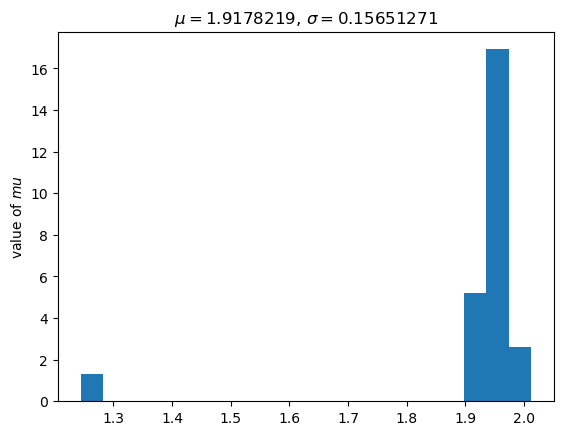

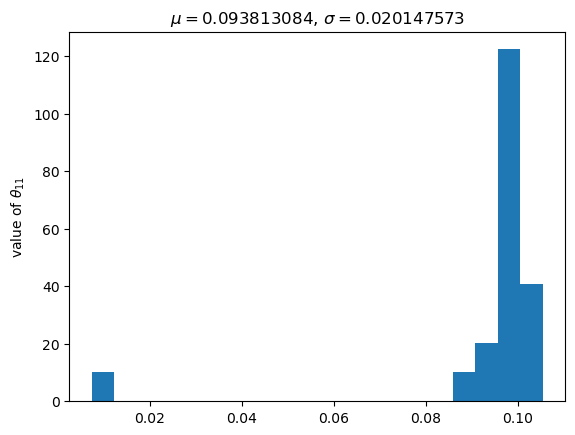

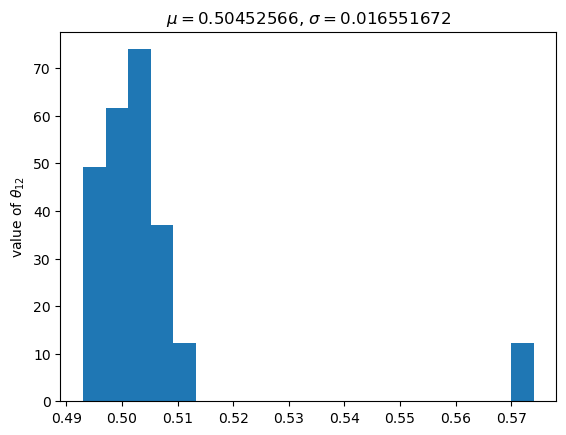

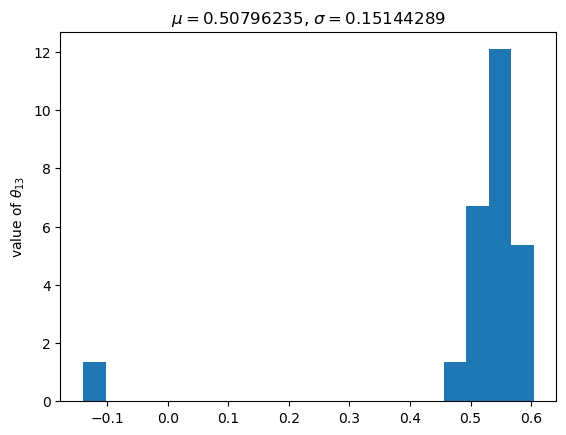

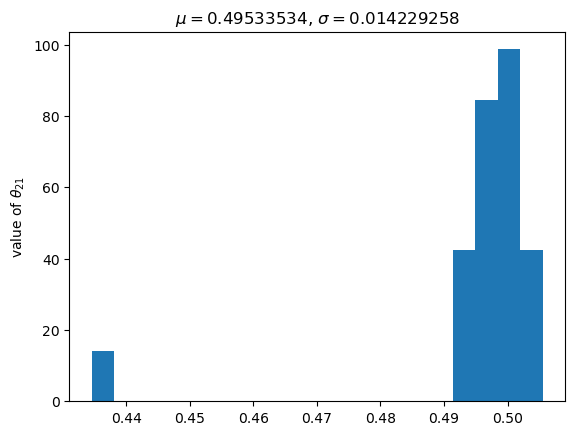

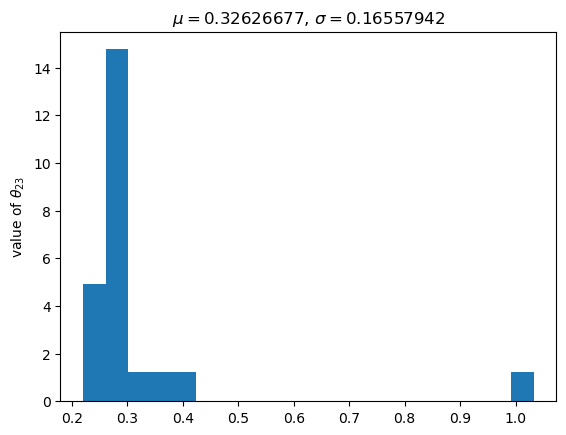

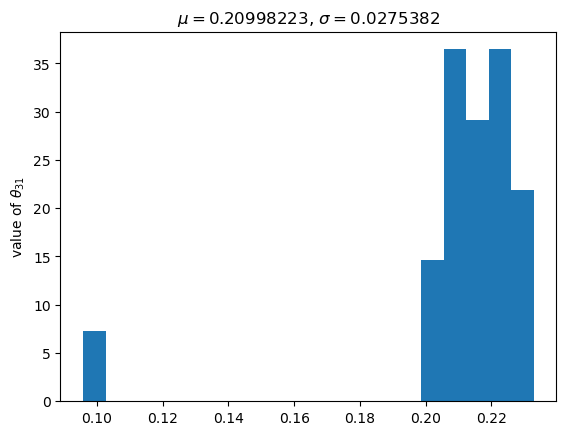

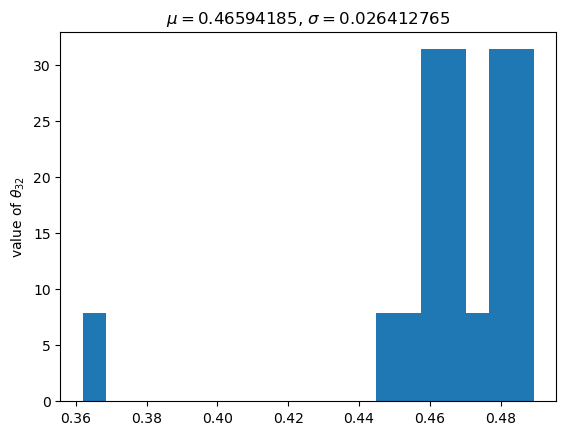

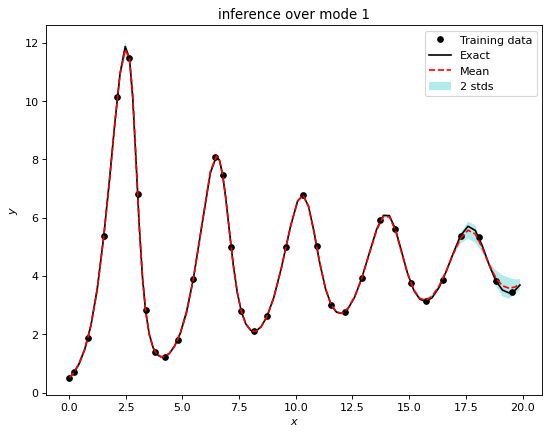

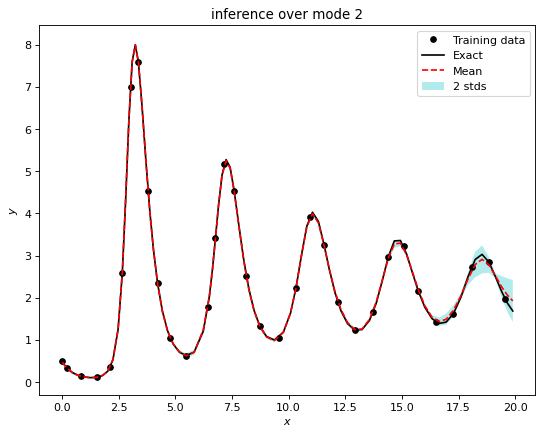

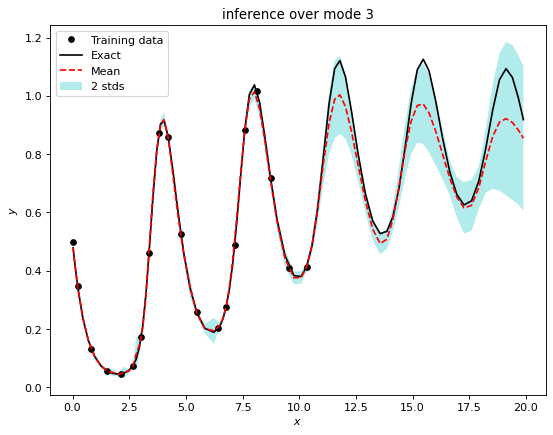

In [12]:
u_pred, mu_pred, r1_pred, r2_pred, r3_pred, r4_pred, r5_pred, r6_pred, r7_pred = model.predict(t_test, samples, processes, pde_fn=None)
plots(u_pred, t_test, u_test, t_u_train, u_train)